In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

def st_scatter_ax(ax, x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean(numeric_only=True)
    norm_sem  = norm_.groupby(bin_type).sem(numeric_only=True)
    norm_std  = norm_.groupby(bin_type).std(numeric_only=True)
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [5]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [6]:
from merfish_datasets import merfish_datasets
import json

directories = merfish_datasets
print(merfish_datasets)

name = 'P28NR_pos'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
fout = full_dirc+'detected_transcripts_v1l23fovs.csv'

f1 = full_dirc+'detected_transcripts.csv'
df = pd.read_csv(f1, nrows=1000)

f2 = full_dirc+'cell_metadata.csv'
df2 = pd.read_csv(f2, index_col=0)
df2['cell_id'] = df2.index


{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [7]:
f_main = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318.h5ad'
f_meta = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240318_xy_operations.json'

adata = ad.read(f_main)
bound_l, bound_r, bound_d = 1400, 3400, 400
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]
adatasub
# df

    

View of AnnData object with n_obs × n_vars = 3696 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'depth', 'width'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [8]:
with open(f_meta, 'r') as fh:
    xy_operations = json.load(fh)
    rotation_angle = xy_operations['rotation']
    ref_line = np.array(xy_operations['ref_line'])
    
print(rotation_angle)
print(ref_line.shape)

-90
(100, 2)


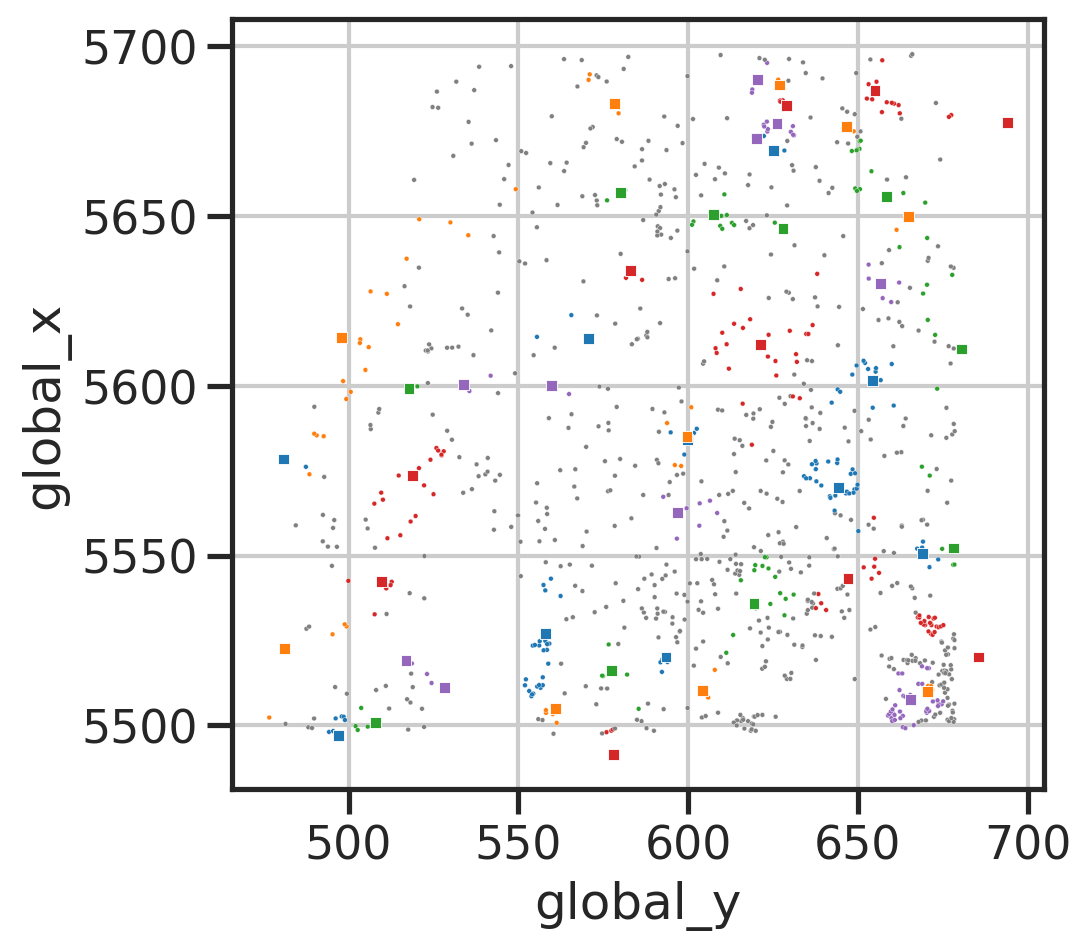

In [9]:
cell_ids = np.unique(df['cell_id'])#[1:] # .unique()
cell_ids_real = cell_ids[1:]
colors = [f'C{i}' for i in range(5)] 
cell_palette = pd.Series([colors[i%5] for i, cid in enumerate(cell_ids_real)], index=cell_ids_real).to_dict()
cell_palette[-1] = 'gray'

# df['cell_color'] = cell_palette.loc[df['cell_id']].values
fig, ax = plt.subplots(figsize=(15,5))
sns.scatterplot(ax=ax, data=df, x='global_y', y='global_x', hue='cell_id', palette=cell_palette, s=3, legend=False)
sns.scatterplot(ax=ax, data=df2.loc[cell_ids_real], x='center_y', y='center_x', hue='cell_id', palette=cell_palette, legend=False, marker='s', s=15)
ax.set_aspect('equal')

In [10]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((34,),
 array([2111, 2155, 2156, 2157, 2158, 2159, 2160, 2202, 2203, 2204, 2205,
        2206, 2207, 2208, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2296,
        2297, 2298, 2299, 2300, 2301, 2302, 2303, 2340, 2341, 2342, 2343,
        2344]))

In [11]:

chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)
           

0 2.6706955432891846
1 4.934008359909058
2 7.0750813484191895
3 9.195908308029175
4 11.294520378112793
5 13.406185865402222
6 16.029452323913574
7 18.323729515075684
8 20.4651198387146
9 22.611736536026
10 25.2047176361084
11 26.855401515960693
12 28.919203281402588
13 31.69613480567932
14 33.619749546051025
15 35.84800601005554
16 37.512962341308594
17 40.09619879722595
18 42.223145484924316
19 43.87057685852051
20 46.17417049407959
21 48.222623348236084
22 50.41993236541748
23 53.41669273376465
24 55.55844855308533
25 57.850388050079346
26 59.97400522232056
27 62.54289436340332
28 64.61274552345276
29 67.08679676055908
30 68.92518186569214
31 71.45024681091309
32 73.8642430305481
33 75.68643140792847
34 78.58084392547607
35 81.31593179702759
36 83.50741219520569
37 85.99949836730957
38 88.59090828895569
39 90.70938920974731
40 93.05203866958618
41 95.24237823486328
42 98.2166953086853
43 100.77183246612549
44 102.85141587257385
45 105.32049131393433
46 107.74264335632324
47 109.75681

In [12]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
73722119,14,0,607.85850,7141.5810,0.0,238.0000,116.00000,2111,Cdh4,ENSMUST00000000314,2596588902656100038
73722120,26,0,773.38560,7154.2437,0.0,1770.6581,233.24442,2111,Cdh4,ENSMUST00000000314,-1
73722121,37,0,712.56120,7163.3975,0.0,1207.4691,318.00000,2111,Cdh4,ENSMUST00000000314,-1
73722122,41,0,683.06506,7165.9106,0.0,934.3568,341.27120,2111,Cdh4,ENSMUST00000000314,2596588902657100046
73722123,42,0,652.13855,7168.9053,0.0,648.0000,369.00000,2111,Cdh4,ENSMUST00000000314,2596588902657100094
...,...,...,...,...,...,...,...,...,...,...,...
95231859,125,453,1360.67640,9288.3330,6.0,1686.6150,1175.78190,2344,Apoe,ENSMUST00000174064,-1
95231860,22,458,1329.72190,9250.4240,6.0,1400.0000,824.76794,2344,Pou3f2,ENSMUST00000178174,-1
95231861,6,464,1290.99910,9178.8640,6.0,1041.4554,162.18051,2344,Unc13c,ENSMUST00000184666,-1
95231862,74,492,1370.56910,9234.1130,6.0,1778.2141,673.74994,2344,Sox10,ENSMUST00000230532,2596588903494100030


In [13]:
df_v1l23.to_csv(fout, header=True, index=False)
# !head $fout

In [14]:
a = df_v1l23[df_v1l23['gene']=='Cdh13']
b = df_v1l23[df_v1l23['gene']=='Sorcs3']
c = df_v1l23[df_v1l23['gene']=='Chrm2']
print(a.shape, b.shape, c.shape)

(1515, 11) (3518, 11) (2550, 11)


<Axes: xlabel='global_x', ylabel='global_y'>

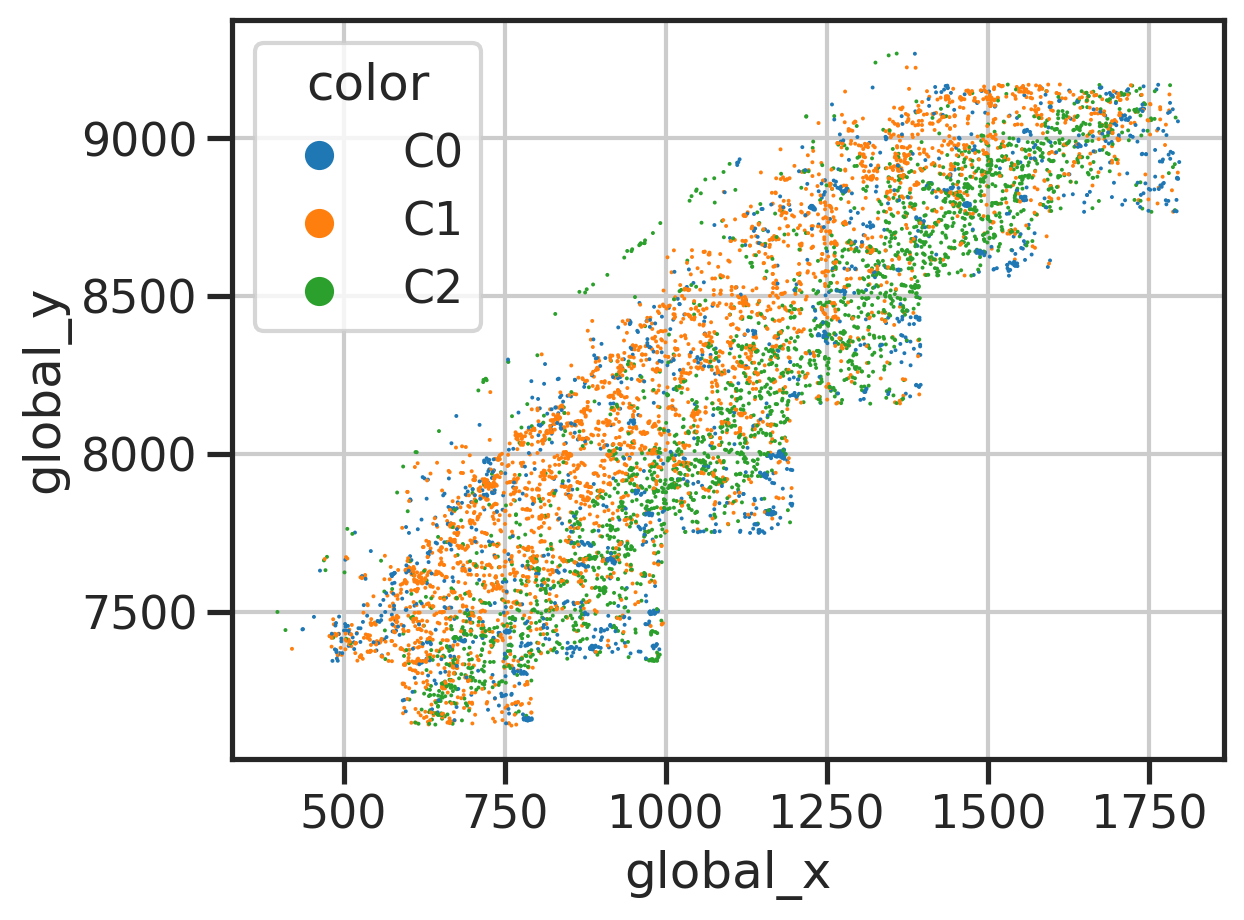

In [15]:
abc = pd.concat([a,b,c])
abc['color'] = ['C0']*len(a)+['C1']*len(b)+['C2']*len(c)
sns.scatterplot(data=abc.sample(frac=1, replace=False), x='global_x', y='global_y', hue='color', hue_order=['C0', 'C1', 'C2'], s=2, edgecolor='none')

# get rotation and ref line
# calculate the width and the depth as cells

In [16]:
# depth ref
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [17]:
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)].copy()

x = abc['global_x'].values
y = abc['global_y'].values
xr, yr = rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 
print(len(abc))

abc['x'] = xr
abc['y'] = yr
abc['depth'] = ref_line_obj.ndist_to_qps(XY)
abc['width'] = ref_line_obj.tdist_to_qps(XY)


cond_spots = np.all([
    abc['width'] > bound_l, 
    abc['width'] < bound_r, 
    abc['depth'] < bound_d, 
], axis=0)

abc = abc[cond_spots]
print(len(abc))
abc.value_counts('gene').reindex(query_genes) 

7583
4884


gene
Cdh13      785
Sorcs3    2728
Chrm2     1371
dtype: int64

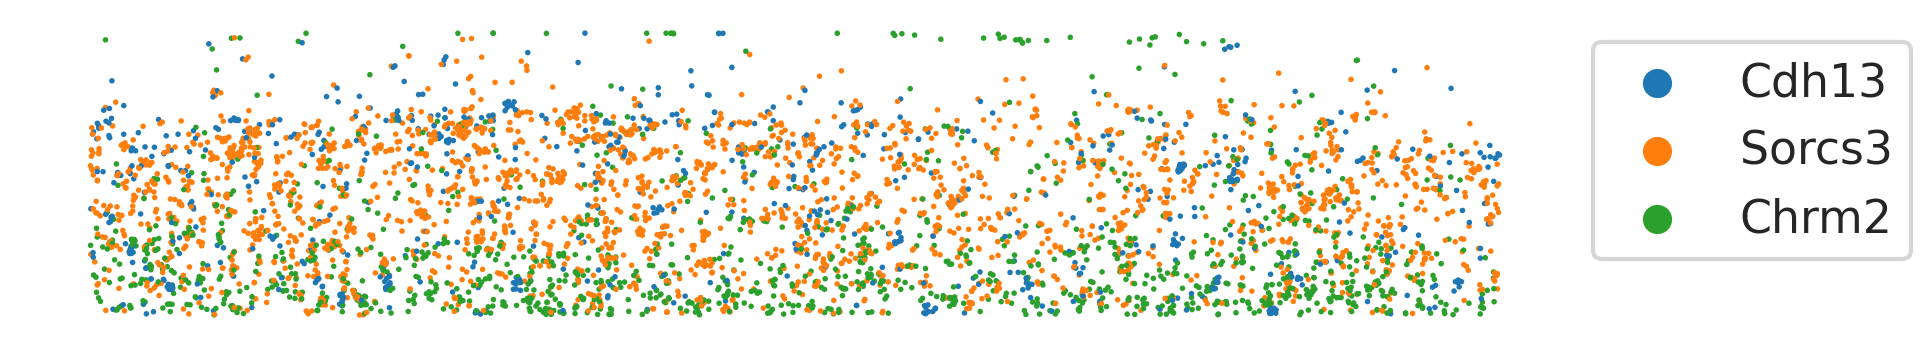

In [18]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()